tobac example: Tracking of precipitation features
===
This example notebook demonstrates the use of tobac to track precipitation features from isolated deep convective clouds.

The simulation results used in this example were performed as part of the ACPC deep convection intercomparison  case study (http://acpcinitiative.org/Docs/ACPC_DCC_Roadmap_171019.pdf) with WRF using the Morrison microphysics scheme.

The data used in this example is downloaded from "zenodo link" automatically as part of the notebooks (This only has to be done once for all the tobac example notebooks).

**Import necessary python libraries:**

In [1]:
# Import libraries
import iris
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import iris.plot as iplt
import iris.quickplot as qplt
import datetime
import shutil
from six.moves import urllib
from pathlib import Path

%matplotlib inline

In [2]:
# Import tobac itself
import tobac

print("using tobac version", str(tobac.__version__))

using tobac version 1.5.5


In [3]:
# Disable a few warnings:
import warnings

warnings.filterwarnings("ignore", category=UserWarning, append=True)
warnings.filterwarnings("ignore", category=RuntimeWarning, append=True)
warnings.filterwarnings("ignore", category=FutureWarning, append=True)
warnings.filterwarnings("ignore", category=pd.io.pytables.PerformanceWarning)

**Download example data:**

Actual download has to be performed only once for all example notebooks!

In [4]:
data_out = Path("../")

In [5]:
# Download the data: This only has to be done once for all tobac examples and can take a while
data_file = list(data_out.rglob("data/Example_input_Precip.nc"))
if len(data_file) == 0:
    file_path = "https://zenodo.org/records/3195910/files/climate-processes/tobac_example_data-v1.0.1.zip"
    # file_path='http://zenodo..'
    tempfile = Path("temp.zip")
    print("start downloading data")
    request = urllib.request.urlretrieve(file_path, tempfile)
    print("start extracting data")
    shutil.unpack_archive(tempfile, data_out)
    tempfile.unlink()
    print("data extracted")
    data_file = list(data_out.rglob("data/Example_input_Precip.nc"))

**Load Data from downloaded file:**

In [6]:
Precip = iris.load_cube(str(data_file[0]), "surface_precipitation_average")

In [7]:
# display information about the iris cube containing the surface precipitation data:
display(Precip)

Surface Precipitation Average (mm h-1),time,south_north,west_east
Shape,47,198,198
Dimension coordinates,,,
time,x,-,-
south_north,-,x,-
west_east,-,-,x
Auxiliary coordinates,,,
projection_y_coordinate,-,x,-
y,-,x,-
latitude,-,x,x
longitude,-,x,x


In [8]:
# Set up directory to save output and plots:
savedir = Path("Save")
if not savedir.is_dir():
    savedir.mkdir()
plot_dir = Path("Plot")
if not plot_dir.is_dir():
    plot_dir.mkdir()

**Feature detection:**

Feature detection is perfomed based on surface precipitation field and a range of thresholds

In [9]:
# Dictionary containing keyword options (could also be directly given to the function)
parameters_features = {}
parameters_features["position_threshold"] = "weighted_diff"
parameters_features["sigma_threshold"] = 0.5
parameters_features["min_distance"] = 0
parameters_features["sigma_threshold"] = 1
parameters_features["threshold"] = [1, 2, 3, 4, 5, 10, 15]  # mm/h
parameters_features["n_erosion_threshold"] = 0
parameters_features["n_min_threshold"] = 3

In [10]:
# get temporal and spation resolution of the data
dxy, dt = tobac.get_spacings(Precip)

In [11]:
# Feature detection based on based on surface precipitation field and a range of thresholds
print("starting feature detection based on multiple thresholds")
Features = tobac.feature_detection_multithreshold(Precip, dxy, **parameters_features)
print("feature detection done")
Features.to_hdf(savedir / "Features.h5", "table")
print("features saved")

starting feature detection based on multiple thresholds


feature detection done
features saved


**Segmentation:**

Segmentation is performed based on a watershedding and a threshold value:

In [12]:
# Dictionary containing keyword arguments for segmentation step:
parameters_segmentation = {}
parameters_segmentation["method"] = "watershed"
parameters_segmentation["threshold"] = 1  # mm/h mixing ratio

In [13]:
# Perform Segmentation and save resulting mask to NetCDF file:
print("Starting segmentation based on surface precipitation")
Mask, Features_Precip = tobac.segmentation_2D(
    Features, Precip, dxy, **parameters_segmentation
)
print(
    "segmentation based on surface precipitation performed, start saving results to files"
)
iris.save([Mask], savedir / "Mask_Segmentation_precip.nc", zlib=True, complevel=4)
Features_Precip.to_hdf(savedir / "Features_Precip.h5", "table")
print("segmentation surface precipitation performed and saved")

Starting segmentation based on surface precipitation


segmentation based on surface precipitation performed, start saving results to files
segmentation surface precipitation performed and saved


**Trajectory linking:**

Trajectory linking is performed using the trackpy library (http://soft-matter.github.io/trackpy). This takes the feature positions determined in the feature detection step into account but does not include information on the shape of the identified objects.

In [14]:
# Dictionary containing keyword arguments for the linking step:
parameters_linking = {}
parameters_linking["method_linking"] = "predict"
parameters_linking["adaptive_stop"] = 0.2
parameters_linking["adaptive_step"] = 0.95
parameters_linking["extrapolate"] = 0
parameters_linking["order"] = 1
parameters_linking["subnetwork_size"] = 100
parameters_linking["memory"] = 0
parameters_linking["time_cell_min"] = 5 * 60
parameters_linking["method_linking"] = "predict"
parameters_linking["v_max"] = 10

In [15]:
# Perform trajectory linking using trackpy and save the resulting DataFrame:
Track = tobac.linking_trackpy(Features, Precip, dt=dt, dxy=dxy, **parameters_linking)
Track.to_hdf(savedir / "Track.h5", "table")

Frame 46: 18 trajectories present.


**Visualistation:**

    

In [16]:
# Set extent for maps plotted in the following cells ( in the form [lon_min,lon_max,lat_min,lat_max])
axis_extent = [-95, -93.8, 29.5, 30.6]

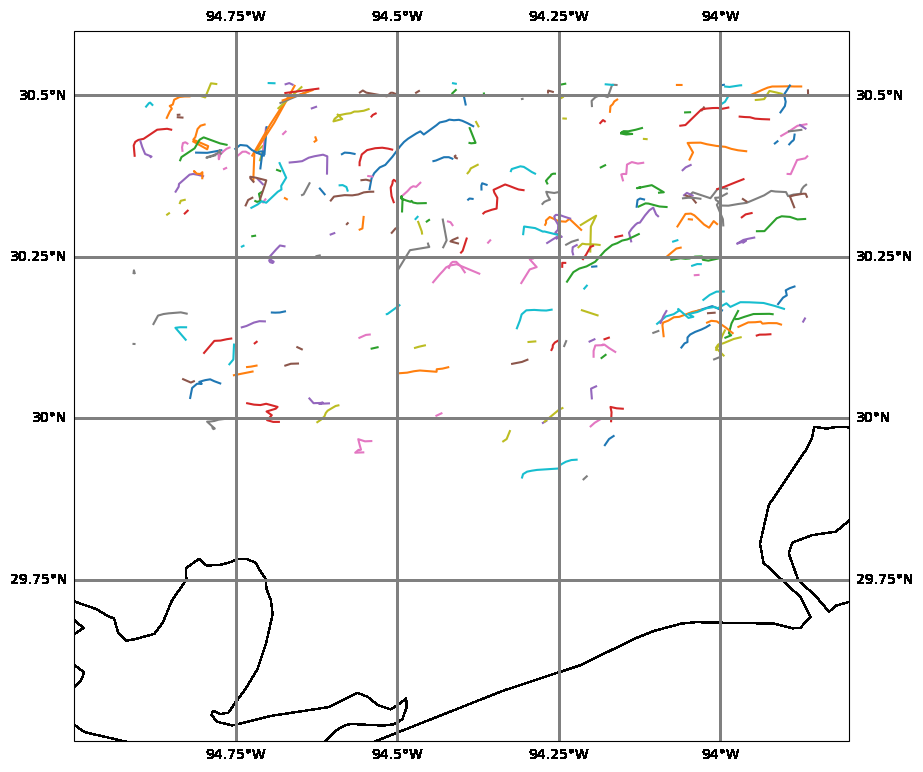

In [17]:
# Plot map with all individual tracks:
import cartopy.crs as ccrs

fig_map, ax_map = plt.subplots(
    figsize=(10, 10), subplot_kw={"projection": ccrs.PlateCarree()}
)
ax_map = tobac.map_tracks(Track, axis_extent=axis_extent, axes=ax_map)

In [18]:
# Create animation showing tracked cells with outline of precipitation features and the and surface precipitation as a background field:
animation_tobac = tobac.animation_mask_field(
    track=Track,
    features=Features,
    field=Precip,
    mask=Mask,
    axis_extent=axis_extent,  # figsize=figsize,orientation_colorbar='horizontal',pad_colorbar=0.2,
    vmin=0,
    vmax=60,
    extend="both",
    cmap="Blues",
    interval=500,
    figsize=(10, 10),
    plot_outline=True,
    plot_marker=True,
    marker_track="x",
    plot_number=True,
    plot_features=True,
)

In [19]:
# Display animation:
from IPython.display import HTML, Image, display

HTML(animation_tobac.to_html5_video())

<Figure size 640x480 with 0 Axes>

In [20]:
# # Save animation to file
# savefile_animation=plot_dir / 'Animation.mp4'
# animation_tobac.save(savefile_animation,dpi=200)
# print(f'animation saved to {savefile_animation}')

Text(0, 0.5, 'counts')

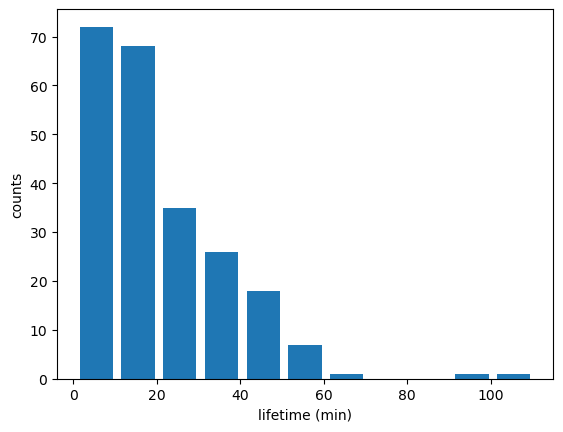

In [21]:
# Lifetimes of tracked features:
fig_lifetime, ax_lifetime = plt.subplots()
tobac.plot_lifetime_histogram_bar(
    Track, axes=ax_lifetime, bin_edges=np.arange(0, 120, 10), density=False, width_bar=8
)
ax_lifetime.set_xlabel("lifetime (min)")
ax_lifetime.set_ylabel("counts")